<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
</center>
Авторы материала: аспирант Мехмата МГУ Евгений Колмаков, программист-исследователь Mail.ru Group Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3. Опциональная часть 
## <center> Реализация алгоритма построения дерева решений

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

**Необходимо реализовать класс `DecisionTree`**

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    `max_depth` - максимальная глубина дерева (по умолчанию - `numpy.inf`); 
    `min_samples_split` - минимальное число объектов в вершине, при котором происходит её разбиение (по умолчанию - 2); 
    `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy', для регрессии - 'variance' или 'mad_median'; 
    по умолчанию - 'gini');
    
    Функционал, значение которого максимизируется для поиска оптимального разбиения в данной вершине имеет вид
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    где $X$ - выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ - разбиение выборки $X$ на две части 
    по предикату $[x_j < t]$, а $F(X)$ -критерий разбиения.
    
    Для классификации: пусть $p_i$ - доля объектов $i$-го класса в выборке $X$.
    
    'gini': Неопределенность Джини $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Энтропия $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    Для регрессии: $y_j = y(x_j)$ - ответ на объекте $x_j$, $y = (y_1, \dots, y_{|X|})$ - вектор ответов.
    
    'variance': Дисперсия (среднее квадратичное отклонение от среднего) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
    'mad_median': Среднее отклонение от медианы $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- класс имеет методы `fit`, `predict` и `predict_proba`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `DecisionTree`, представляющий собой решающее дерево, обученное по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict_proba` принимает матрицу объектов `X` и возвращает матрицу `P` размера `X.shape[0] x K`, где `K` - число классов, такую что $p_{ij}$ есть вероятность принадлежности объекта, заданного $i$-ой строкой матрицы X к классу $j \in \{1, \dots, K\}$.
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов; в случае классификации - это 
    наиболее многочисленный класс в листе, в который попал объект, а в случае регрессии - среднее значение ответов по 
    всем объектам этого листа;

In [8]:

def entropy(y):    
    _, counts = np.unique(y, return_counts=True)
    return (-sum([cnt/len(y) * np.log2(cnt/len(y)) for cnt in counts]))

def gini(y):
    _, counts = np.unique(y, return_counts=True)
    return (1 - sum([(cnt/len(y))**2 for cnt in counts]))

def variance(y):
    sum_ = sum([yi for yi in y])
    len_ = len(y)
    return (1/len_ * sum([(yj - (1/len_) * sum_)**2 for yj in y] ))

def mad_median(y):
    len_ = len(y)
    med = np.median(y)
    return (1/len_ * sum([np.abs(yj - med) for yj in y]))


In [9]:
class Node:
    is_final = False
    def __init__(self, cur_depth=0):
        self.cur_depth = cur_depth
        

In [16]:


class DecisionTree(BaseEstimator):
    
    cur_depth = 0
    root_node = Node()
    
    def __init__(self, max_depth=np.inf, min_samples_split=2, 
                 criterion='gini', debug=False):
            self.max_depth = max_depth
            self.min_samples_split = min_samples_split
            self.criterion = criterion
            self.debug = debug
            self._dict = {'gini' : gini, 'entropy' : entropy, 'variance' : variance, 'mad_median' : mad_median}
            
    
    def _Q(self, x, y, t):
        func = self._dict[self.criterion]
        yl = [yi for i, yi in enumerate(y) if x[i] < t]
        yr = [yi for i, yi in enumerate(y) if x[i] >= t]
        return (func(y) - (len(yl)/len(y)) * func(yl) - (len(yr)/len(y)) * func(yr))
    
    def _split(self, X, y, index, t):
        Xl = np.array([xi for xi in X if xi[index] < t])
        Xr = np.array([xi for xi in X if xi[index] >= t])
        yl = np.array([yi for i, yi in enumerate(y) if X[i][index] < t])
        yr = np.array([yi for i, yi in enumerate(y) if X[i][index] >= t])
        return Xl, Xr, yl, yr
                    
    
    def _build(self, X, y, depth):

        node = Node(cur_depth=depth)
        node.cur_depth += 1
        
        if ((node.cur_depth > self.max_depth) | (len(y) < self.min_samples_split)):
            node.is_final = True
            if ((self.criterion == 'gini') | (self.criterion == 'entropy')):
                uniq_vals, counts = np.unique(y, return_counts=True)
                node.pred_proba_list = np.zeros(10)
                for uniq, cnt in zip(uniq_vals, counts):
                    node.pred_proba_list[uniq] = cnt/len(y)
                node.pred = sorted(zip(counts, uniq_vals), reverse=True)[0][1]
               # print('cur_depth : ', node.cur_depth, 'proba : ', node.pred_proba_list)
                
                return node
            else :
#                 print ('cur_depth', node.cur_depth)
                node.pred = np.mean(y)
                return node
        else :
            qs = []
            parameters = []

            for index, x in enumerate(np.transpose(X)):
                x_sorted = sorted(x)
                y_sorted = [y for _, y in sorted(zip(x, y))]
                x_uniq_sorted = np.unique(x_sorted)
                if (len(x_uniq_sorted) > 1):
                    for value, next_value in zip(x_uniq_sorted[:-1], x_uniq_sorted[1:]) :
                        t = (value + next_value) / 2 
                        q = self._Q(x_sorted, y_sorted, t)
                        qs.append(q)
                        parameters.append((index, t))
#            print(qs)
            best_param = sorted(zip(qs, parameters), reverse=True)

            best_index = best_param[0][1][0]
            best_t = best_param[0][1][1]
            node.index = best_index 
            node.t = best_t
            Xl, Xr, yl, yr = self._split(X, y, best_index, best_t)
            
#             print('cur_depth : ', node.cur_depth, 'index : ', best_index, 't : ', best_t, \
#                   len([x for x in np.transpose(X)[best_index] if x < best_t]), \
#                   len([x for x in np.transpose(X)[best_index] if x >= best_t]), 'q = ', best_param[0][0])
            node.left = self._build(Xl, yl, node.cur_depth)
            node.right = self._build(Xr, yr, node.cur_depth)
        
        return node
    
    def fit(self, X, y):
        self.root_node = self._build(X, y, 0)
        return self
        
        
    def f(self, node, x):
        if (node.is_final):
            return (node.pred)
        else :
            if (x[node.index] < node.t):
                y = self.f(node.left, x)
            else :
                y = self.f(node.right, x)
        return y
    
    def g(self, node, x):
        if (node.is_final):
            return (node.pred_proba_list)
        else :
            if (x[node.index] < node.t):
                y = self.g(node.left, x)
            else :
                y = self.g(node.right, x)
        return y
    
    def predict(self, X):
        node = self.root_node
        y = np.array([self.f(node, x) for x in X])
        return y
        
    def predict_proba(self, X):
        node = self.root_node
        y = np.array([self.g(node, x) for x in X])
        return y

## Тестирование реализованного алгоритма

### Классификация

С помощью метода `load_digits` загрузите датасет `digits`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие решающие деревья и убедитесь, что критерии gini и entropy дают разные результаты.

In [26]:
# Ваш код здесь
digits = load_digits()
X = digits['data']
y = digits['target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=17)

С помощью 5-кратной кросс-валидации (`GridSearchCV`) подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - range(3, 11), а для criterion - {'gini', 'entropy'}. Критерий качества `scoring`='accuracy'.

In [ ]:
# Ваш код здесь
tree_clasifier = DecisionTree()
tree_params = {'max_depth' : list(range(3, 11)), 'criterion' : ['gini', 'entropy']}
grid_estimator = GridSearchCV(tree_clasifier, tree_params, scoring='accuracy', cv=5)
grid_estimator.fit(X_train, y_train)

In [28]:
grid_estimator.best_score_

0.86082115518441193

In [30]:
grid_estimator.best_params_

{'criterion': 'entropy', 'max_depth': 8}

In [56]:
max(y_valid)

9

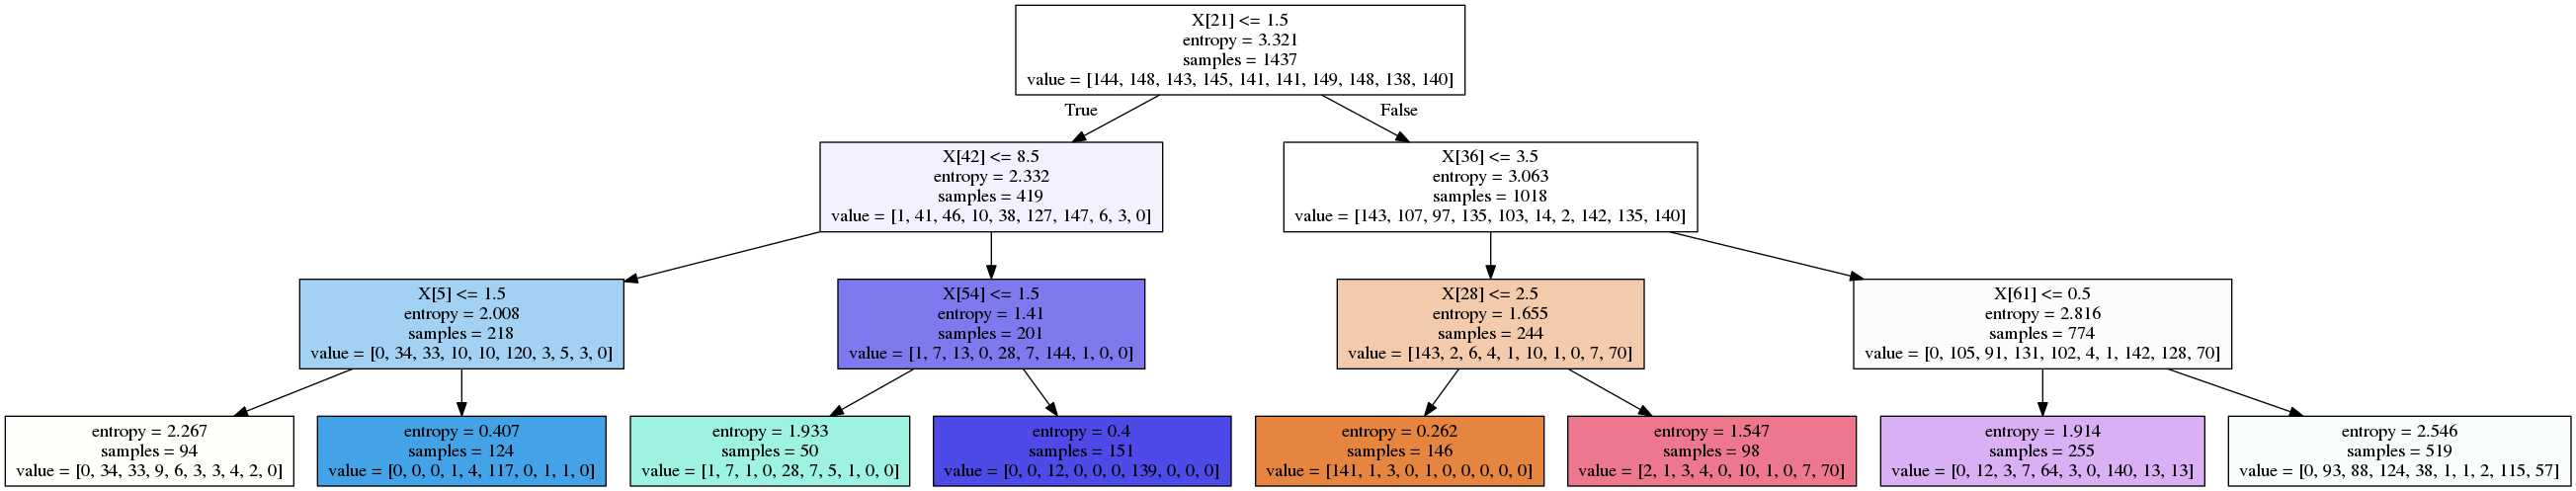

In [17]:

from sklearn.tree import DecisionTreeClassifier, export_graphviz
clf = DecisionTreeClassifier(max_depth=3, criterion='entropy')
clf.fit(X_train, y_train)

export_graphviz(clf, out_file='clf.dot', filled=True)

!dot -Tpng clf.dot -o clf.png

from IPython.display import Image
Image("clf.png")

Постройте графики средних значений критерия качества `accuracy` для критериев `gini` и `entropy` в зависимости от `max_depth`.

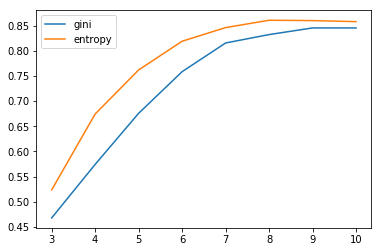

In [43]:
# Ваш код здесь
y_1 = grid_estimator.cv_results_['mean_test_score'][:8]
y_2 = grid_estimator.cv_results_['mean_test_score'][8:]
x = list(range(3,11))
plt.plot(x, y_1, label='gini' )
plt.plot(x, y_2, label='entropy')
plt.legend()
plt.show()

**Выберите верные утверждения:**
1. Оптимальное значение max_depth для каждого критерия достигается внутри отрезка [3, 10] (то есть на отрезке [4, 9]).
2. На отрезке [3, 10] построенные графики не пересекаются.
3. На отрезке [3, 10] построенные графики пересекаются ровно один раз.
4. Наилучшее качество при max_depth на интервале [3, 10] достигается на критерии gini.
5. Хотя бы для одного из критериев значение accuracy строго возрастает с ростом значения max_depth на интервале [3, 10].

1, 2

**Чему равны найденные оптимальные значения параметров max_depth и criterion?**
1. max_depth = 4, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. max_depth = 10, criterion = 'gini';
5. max_depth = 3, criterion = 'entropy';
6. max_depth = 9, criterion = 'gini';

In [44]:
grid_estimator.best_params_

{'criterion': 'entropy', 'max_depth': 8}

Используя найденные оптимальные значения max_depth и criterion, обучите решающее дерево на X_train, y_train и вычислите вероятности принадлежности к классам для X_test.

In [67]:
# Ваш код здесь
tree = DecisionTree(max_depth=8, criterion='entropy')
tree.fit(X_train, y_train)

y_pred_proba = tree.predict_proba(X_valid)

Для полученной матрицы вычислите усредненные по всем объектам из `X_test` значения вероятностей принадлежности к классам.

In [68]:
np.max(np.mean(y_pred_proba, axis=0))


0.1196825396825397

**Вопрос:** Чему равна максимальная вероятность в полученном векторе?
1. 0.11218791
2. 0.11783761
3. 1.0
4. 0.0875

### Регрессия

С помощью метода `load_boston` загрузите датасет `boston`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие регрессионные деревья и убедитесь, что критерии `variance` и `mad_median` дают разные результаты.

In [70]:
# Ваш код здесь
boston = load_boston()
X = boston['data']
y = boston['target']


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

С помощью 5-кратной кросс-валидации подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - `range(2, 9)`, а для `criterion` - {'variance', 'mad_median'}. Критерий качества `scoring`='neg_mean_squared_error'.

In [17]:
# Ваш код здесь
tree_params = {'max_depth' : list(range(2, 9)), 'criterion' : ['variance', 'mad_median']}
tree = DecisionTree()
grid_regressor = GridSearchCV(tree, tree_params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)
grid_regressor.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  4.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTree(criterion='gini', debug=False, max_depth=inf,
       min_samples_split=2),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'criterion': ['variance', 'mad_median'], 'max_depth': [2, 3, 4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

In [94]:
print(grid_regressor.best_score_)
print(grid_regressor.best_params_)

-21.0380757171
{'max_depth': 5, 'criterion': 'variance'}


Постройте графики средних значений критерия качества `neg_mean_squared_error` для критериев `variance` и `mad_median` в зависимости от `max_depth`.

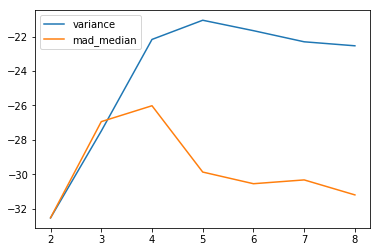

In [18]:
# Ваш код здесь
y_1 = grid_regressor.cv_results_['mean_test_score'][:7]
y_2 = grid_regressor.cv_results_['mean_test_score'][7:]
x = list(range(2,9))
plt.plot(x, y_1, label='variance' )
plt.plot(x, y_2, label='mad_median')
plt.legend()
plt.show()

**Выберите верные утверждения:**
1. На отрезке [2, 8] построенные графики не пересекаются.
2. На отрезке [2, 8] построенные графики пересекаются ровно один раз.
3. Оптимальное значение max_depth для каждого из критериев достигается на границе отрезка [2, 8].
4. Наилучшее качество при max_depth in range(2, 9) достигается на критерии variance.
5. График качества ровно для одного из критериев имеет явно выраженный пик.

2, 4

**Чему равны найденные оптимальные значения параметров `max_depth` и `criterion`?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median';
6. max_depth = 8, criterion = 'variance';

3